之前写着玩的求单自由度系统地震响应的动力积分python代码，今天整理了下发出来共享下。

包括的动力积分方法有 杜哈梅积分，OpenSees版的Newmarks法，自己实现的Newmarks法，精确解法，显式差分法，快速傅里叶变换法。

最后对各种方法作了总结，包括计算精度，计算效率。

依赖numpy实现，参考书籍有 《结构抗震分析》曲哲老师译；乔普拉教授的结构动力学教程第五版。

最后，我使用了一个神奇的3D绘图库 vedo，简单实现了一个弹簧系统的地震响应的动画演示。这个库非常不错，后续可能改用该库开发 OpenSeesPy的可视化脚本。

能力有限，理解可能有偏差，代码可能有更好的实现，代码可能有误，有问题请及时纠正。😃最后，推荐你用 FFT变换，更快更准，求反应谱会更爽。

In [1]:
import time 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 加载地震波

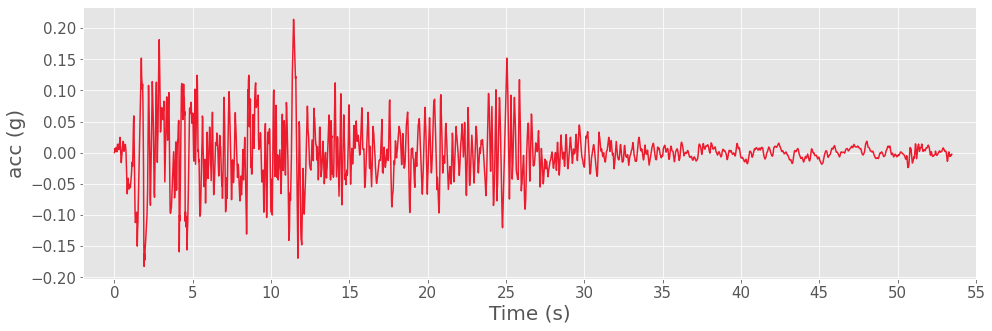

In [2]:
# 加载地面运动，第1列为时间，第2列为数据，单位g
GM = np.loadtxt('ELCENTRO_EW.txt')
ts = GM[:, 0]
acc = GM[:, 1]
dt = ts[1] - ts[0]

# 绘图
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(ts, acc, c='#ed1b2e', lw=1.5)
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('acc (g)', fontsize=20)
ax.set_xlim(-2, 55)
ax.set_xticks(np.linspace(0,55,12))
ax.tick_params(labelsize=15)
plt.show();

# 设置单自由度系统特性

In [3]:
# 设置单自由度特性
T = 0.5              # 周期
wn = 2 * np.pi / T   # 无阻尼圆频率
xi = 0.05            # 阻尼比
wd = wn * np.sqrt(1 - xi ** 2)  # 有阻尼原频率
g = 9.81   # 重力加速度 m/s2

# 杜哈梅积分 (Duhamel's integral)

首先定义单位脉冲响应函数，具体的公式可参见《结构抗震分析》和《结构动力学》，

这里需要注意以下，在《结构抗震》中荷载是地面加速度$\ddot{u}_g$，在《结构动力学》中是定义的是力$p$,
只需要把$p = -m\ddot{u}_g$ 代入，也就是把地面加速度转换为惯性力，就可以得到相同的公式。

In [4]:
# 单位地面加速度脉冲函数 见 结构抗震分析 曲哲 Eq.1.119
def hd(t):  # 单位脉冲位移响应函数
    return -1 / wd * np.exp(-xi * wn * t) * np.sin(wd * t)
def hv(t):  # 单位脉冲速度响应函数，hd(t)的一阶导数
    return xi * wn / wd  * np.exp(-xi * wn * t) * np.sin(wd * t) - np.exp(-xi * wn * t) * np.cos(wd * t)
def ha(t):  # 单位脉冲加速度响应函数，hd(t)的二阶导数
    return -xi**2 * wn**2 / wd  * np.exp(-xi * wn * t) * np.sin(wd * t) + \
            xi * wn * np.exp(-xi * wn * t) * np.cos(wd * t) - \
            (-xi * wn * np.exp(-xi * wn * t) * np.cos(wd * t) - wd * np.exp(-xi * wn * t) * np.sin(wd * t))

单位地面加速度脉冲激励下的自由振动，重现图1.38

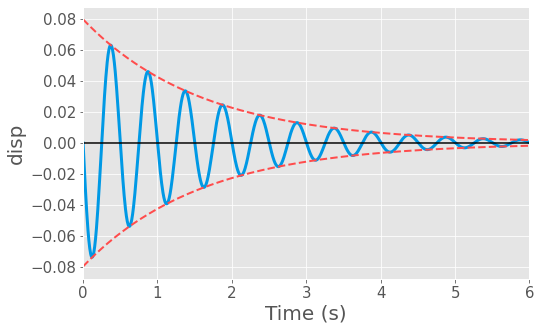

In [5]:
# 单位地面加速度脉冲激励下的自由振动，重现图1.38
tn = np.linspace(0, 6, 1001)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(tn, hd(tn), c='#0099e5', lw=3)
ax.plot(tn, -1 / wd * np.exp(-xi * wn * tn), lw=2, ls='--', c='#ff4c4c')
ax.plot(tn, 1 / wd * np.exp(-xi * wn * tn), lw=2, ls='--', c='#ff4c4c')
ax.hlines(0, 0, 10, color='black')
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('disp', fontsize=20)
ax.set_xlim(0, 6)
ax.tick_params(labelsize=15)
plt.show();

## 利用duhamel积分求解地面加速度响应

注意我这里循环使用了数值积分来计算卷积，计算效率很低，有没有更好的实现呢？反正我暂时没想到，希望有大佬改进一下。😜

In [6]:
# 利用duhamel积分求解地面加速度响应
def duhamel(ts, acc, n_samples=10):
    """
    ts: 地震波的时间数组
    acc: 地震波的加速度时间序列值
    n_samples: 求积分所用的采样加密倍数,越大意味着加速度序列被加密采样
    """

    t_min = np.min(ts)
    t_max = np.max(ts)
    t_new = np.linspace(t_min, t_max, (len(ts) - 1) * n_samples)
    acc_new = np.interp(t_new, ts, acc)  # 线性插值
    
    u = []
    v = []
    a = []
    # 卷积数值积分
    for i, t_ in enumerate(ts):
        idx = t_new <= t_
        du = acc_new[idx] * hd(t_ - t_new[idx])
        dv = acc_new[idx] * hv(t_ - t_new[idx])
        #da = acc_new[idx] * ha(t_ - t_new[idx])
        u_ = np.trapz(du, t_new[idx])
        v_ = np.trapz(dv, t_new[idx])
        #a_ = np.trapz(da, t_new[idx]) - acc[i] 
        a_ = -2*xi*wn*v_ - wn**2*u_ - acc[i]  # 代入动力方程求解加速度
        u.append(u_)
        v.append(v_)
        a.append(a_)
    return np.array(u), np.array(v), np.array(a)

# 精确解法

所谓的精确解法在《结构抗震分析中》称为 Nigam-Jennings法(127页，原书公式有误，勘误见曲老师公众号)。
在《结构动力学》中称的是 基于激励插值的方法（interpolation of excitation，159页5.2节)。
这个方法就是认为激励在一个时间步内线性变化，从而利用线性激励下的精确公式解建立递推关系。
如果把 $p = -m\ddot{u}_g$ 代入，两本书其实可以得到一样的解，也可以发现 《结构抗震分析中》中的错误地方。

由于地震加速度是离散采样的，在每个时间步内我们一般就是当作线性变化的，所以这个方法可以认为是精确解（对于线性系统）。

下面是相应的函数：

In [7]:
#  利用精确解法
def nigam_jennings(dt, acc):
    """
    dt: 时间步；
    acc: 加速度序列。
    """
    a11 = np.exp(-xi*wn*dt)*(xi/np.sqrt(1-xi**2)*np.sin(wd*dt)+np.cos(wd*dt))
    a12 = np.exp(-xi*wn*dt)/wd*np.sin(wd*dt)
    a21 = - wn / np.sqrt(1-xi**2) * np.exp(-xi*wn*dt)*np.sin(wd*dt)
    a22 = np.exp(-xi*wn*dt)*(np.cos(wd*dt)-xi/ np.sqrt(1-xi**2)*np.sin(wd*dt))
    b11 = np.exp(-xi*wn*dt)*(((2*xi**2-1)/wn**2/dt+xi/wn)*np.sin(wd*dt)/wd+(2*xi/wn**3/dt+1/wn**2)*np.cos(wd*dt)) - 2*xi/wn**3/dt
    b12 = -np.exp(-xi*wn*dt)*(((2*xi**2-1)/wn**2/dt)*np.sin(wd*dt)/wd+2*xi/wn**3/dt*np.cos(wd*dt))-1/wn**2+2*xi/wn**3/dt
    b21 = -1/wn**2*(-1/dt+np.exp(-xi*wn*dt)*((wn/ np.sqrt(1-xi**2)+xi/dt/ np.sqrt(1-xi**2))*np.sin(wd*dt)+1/dt*np.cos(wd*dt)))
    b22 = -1/wn**2/dt * (1-np.exp(-xi*wn*dt)*(xi / np.sqrt(1-xi**2)*np.sin(wd*dt)+np.cos(wd*dt)))
    d = [0]
    v = [0]
    a = [-acc[0]]
    for i in range(len(acc) - 1):
        d_ = a11 * d[i] + a12 * v[i] + b11 * acc[i] + b12 * acc[i+1]
        v_ = a21 * d[i] + a22 * v[i] + b21 * acc[i] + b22 * acc[i+1]
        a_ = -acc[i+1] - wn**2*d_ - 2*xi*wn*v_
        d.append(d_)
        v.append(v_)
        a.append(a_)
    return np.array(d), np.array(v), np.array(a)

In [8]:
d1,v1,a1 = duhamel(ts, acc*g, n_samples=5)  #  加大 n_samples 会更精确，但是计算时间会更高, 但是似乎 n_samples 一定后 误差会饱和，这应该是数值积分误差了
d2,v2,a2 = nigam_jennings(dt, acc*g)

画图比较一下二者的结果，右边是二者相减的结果，而且你也可以改变 duhamel函数中n_samples值，你会发现n_samples越大，二者差距越小。

而且，我们也可以发现，位移的差距很小，但是速度和加速度的差距相比位移大一些。

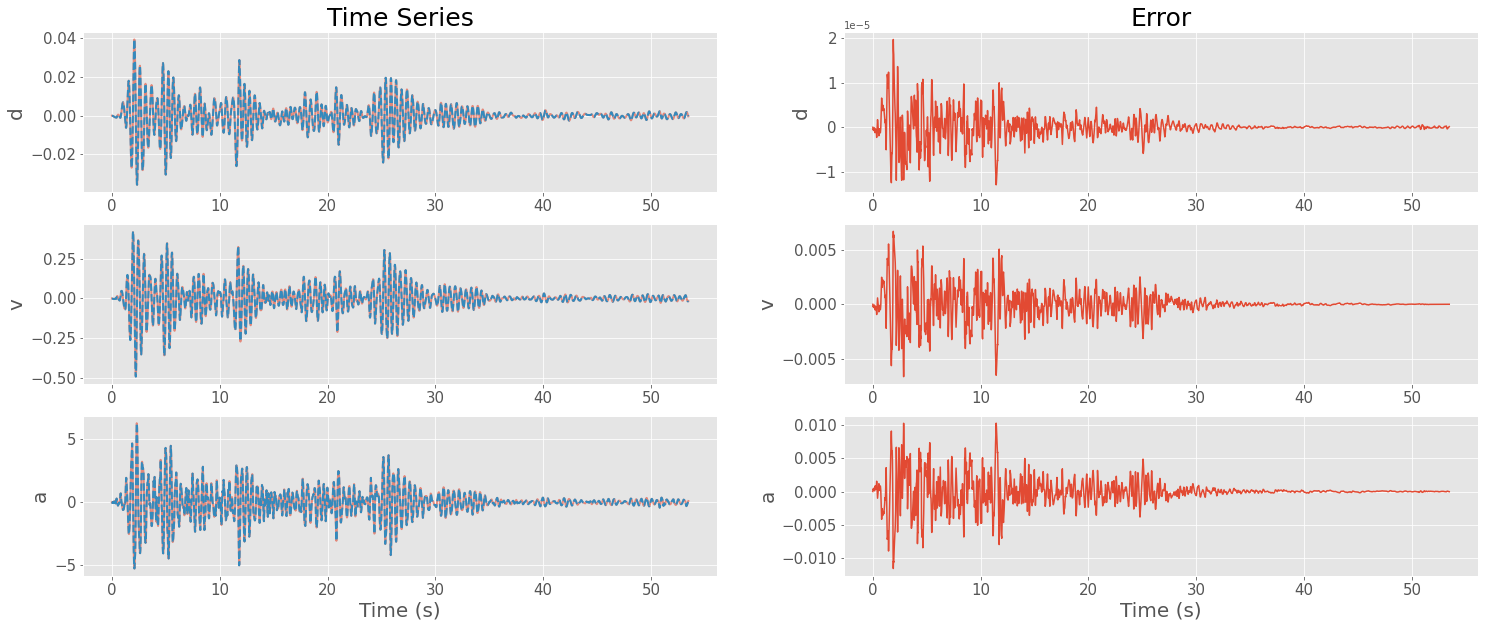

In [9]:
fig, axs = plt.subplots(3,2,figsize=(25,10))
plot_obj = [(d1,d2), (v1,v2), (a1,a2)]
ylabels = ["d","v","a"]
for i in range(3):
    ax = axs[i]
    ax[0].plot(ts,plot_obj[i][0], lw=2, alpha=0.6)
    ax[0].plot(ts,plot_obj[i][1], lw=2, ls='--', alpha=1)
    ax[1].plot(ts, plot_obj[i][1]-plot_obj[i][0])
    for ax_ in ax:
        ax_.set_ylabel(ylabels[i], fontsize=20)
        ax_.tick_params(labelsize=15)
axs[2,0].set_xlabel('Time (s)', fontsize=20)
axs[2,1].set_xlabel('Time (s)', fontsize=20)
axs[0,0].set_title('Time Series', fontsize=25)
axs[0,1].set_title('Error', fontsize=25)
plt.show();

# 利用 OpenSeesPy 中的 纽马克积分方案

话不多说，直接上代码。

细心的你，会发现我没有用recorder函数来生成结果文件再读取，我直接用的内部函数提取的结果。
因为IO会显著增加计算时间，对于要分析很多模型的话，建议使用函数提取结果，不要读写文件，非常慢！

In [10]:
import openseespy.opensees as op

def opensees_():
    mass = 10   # 随意设置一个质量即可
    k = wn**2 *mass
    alpha_m = 2 * xi * wn
    op.wipe()
    op.model('basic', '-ndm', 1, '-ndf', 1)
    op.node(1, 0)
    op.fix(1, 1)
    op.node(2, 0)
    op.mass(2, mass, 0., 0.)
    op.uniaxialMaterial('Elastic', 1, k)
    op.element('zeroLength', 1, 1, 2, "-mat", 1, "-dir", 1, '-doRayleigh', 1)
    op.rayleigh(alpha_m, 0, 0, 0)
    op.timeSeries('Path', 1, '-dt', ts[1]-ts[0], '-values', *acc)
    op.pattern('UniformExcitation', 1, 1, '-accel', 1, '-fact', g)
    op.wipeAnalysis()

    op.algorithm('Linear')
    op.system('SparseGeneral')
    op.numberer('RCM')
    op.constraints('Transformation')
    op.integrator('Newmark', 0.5, 1/6)   # 这个参数取值对应 线性加速度法
    op.analysis('Transient')
    op.test('EnergyIncr', 1e-10, 10, 0, 2)
    d = [0]
    v = [0]
    a = [0]
    for _ in range(len(ts)-1):
        op.analyze(1, dt)
        d.append(op.nodeDisp(2, 1))   # 读取结果
        v.append(op.nodeVel(2,1))    # 读取结果
        a.append(op.nodeAccel(2, 1)) # 读取结果
    return np.array(d), np.array(v), np.array(a)

# 中心差分法

显式差分特别依赖于时间步，越小越精确。为了对地震波重采样，定义了一个alpha参数来缩小时间步，和duhamel函数中n_samples参数作用差不多。只不过反着来的。哈哈😏

In [11]:
# 显示差分法
def central_difference(dt, acc, alpha=1):
    # 重新插值
    n = len(acc)
    ts = np.linspace(0, (n-1)*dt, n)   # 原始时间

    dt = dt * alpha
    ts_new = np.arange(0, ts[-1]+dt, dt)

    acc_new = np.interp(ts_new, ts, acc)

    acc0 = -acc[0]
    x_01 = dt**2 / 2 * acc0
    k_hat = 1 / dt**2 + wn * xi / dt
    a = 1 / dt**2 - wn * xi / dt
    b = wn**2 - 2 / dt**2

    x = [0]
    v = [0]
    aa = [acc0]

    # i = 0
    p = -acc[0] - a * x_01 - b * x[0]
    v.append((p/k_hat - x_01) / 2 / dt)
    aa.append((p/k_hat - 2 * x[0] + x_01) / dt**2)
    x.append(p/k_hat)
    x_new = x.copy()

    for i in range(1, len(ts_new)-1):
        p = -acc_new[i] - a * x_new[i-1] - b * x_new[i]
        x_new.append(p/k_hat)
        if ts_new[i+1] in ts[2:]:
            v.append((p/k_hat - x_new[i-1]) / 2 / dt)
            aa.append((p/k_hat - 2 * x_new[i] + x_new[i-1]) / dt**2)
            x.append(p/k_hat)
    return np.array(x), np.array(v), np.array(aa)

# Newmark

Newmark 大法好，定义不同的 gamma，beta对应不同的时间步内加速度响应假定。具体请参见动力学教程

注意在OpenSees中我们使用了 0.5, 1/6 这俩值，对应线性加速度方法，0.5和1/4则是常加速度方法。

In [12]:
# Newmarks
def Newmark(dt, acc, gamma=0.5, beta=1/6):
    acc0 = -acc[0]
    a1 = 1/beta/dt**2 + gamma/beta/dt*2*xi*wn
    a2 = 1/beta/dt+(gamma/beta-1)*2*xi*wn
    a3 = (1/2/beta-1) + dt*(gamma/2/beta-1)*2*xi*wn
    k_hat = wn**2 + a1
    x = [0]
    v = [0]
    a = [acc0]
    for i in range(len(acc)-1):
        acc_temp = -acc[i+1] + a1 * x[i] + a2*v[i] + a3*a[i]
        x.append(acc_temp/k_hat)
        v.append(gamma/beta/dt*(x[i+1]-x[i])+(1-gamma/beta)*v[i]+dt*(1-gamma/2/beta)*a[i])
        a.append(1/beta/dt**2*(x[i+1]-x[i])-1/beta/dt*v[i]-(1/2/beta-1)*a[i])
    return np.array(x), np.array(v), np.array(a)

# 快速傅里叶变换

最后就是快速傅里叶变换了，他先把时间序列从时域变换到频域中，然后在频域中运算，最后再通过傅里叶逆变换到时域中。
至于快不快速，最后在比较吧。（注：快速字眼是傅里叶变换的计算机解法）

至于频域里面怎么计算的，就是基于这个公式：
$$U(\omega) = H(\omega) * P(\omega) $$
其中 $U(\omega)$是位移响应的傅里叶变换， $H(\omega)$叫传递函数， $P(\omega)$是荷载力的傅里叶变换。
至于速度和加速度 $V(\omega)=U(\omega) * \omega j$， j代表复数单位，$A(\omega)=-\omega^2 U(\omega) $

In [13]:
# 快速傅里叶变换
def fftsdof(dt, acc):
    n = len(acc)
    Nfft =  int(2 ** np.ceil(np.log2(n)))
    af = np.fft.fft(acc, Nfft)  #对地震动加速度序列作傅里叶变换
    f = np.fft.fftfreq(Nfft, d=dt) # 离散频率点
    omega = 2.0 * np.pi * f
    H = 1 / (omega**2 -2 * omega * xi * wn * 1j - wn**2)   # 传递函数
    u = np.fft.ifft(af * H).real # 快速Fourier逆变换并取实部
    v = np.fft.ifft(af * omega * H * 1j).real # 快速Fourier逆变换并取实部
    a = np.fft.ifft(-af * omega ** 2 * H).real # 快速Fourier逆变换并取实部
    u = u[:n]
    v = v[:n]
    a = a[:n]
    return np.array(u),np.array(v),np.array(a)

# 运行各函数

In [14]:
excute_time = []   # 运行时间列表

n_samples = 1  # duhamel几分中加密，越大越精确，改成10试试
alpha = 1  # central_difference中的加密参数，越小越精确，改成0.1试试

t1 = time.time()
d1,v1,a1 = duhamel(ts, acc*g, n_samples=n_samples)
t2 = time.time()
excute_time.append(t2 - t1)

t1 = time.time()
d2,v2,a2 = nigam_jennings(dt, acc*g)
t2 = time.time()
excute_time.append(t2 - t1)

t1 = time.time()
d3, v3, a3 = opensees_()
t2 = time.time()
excute_time.append(t2 - t1)

t1 = time.time()
d4,v4,a4 = central_difference(dt, acc*g, alpha=alpha)  # 把原来的步长缩小至0.1倍试试，可以改变其他值看看效果，越小计算量越大
t2 = time.time()
excute_time.append(t2 - t1)

t1 = time.time()
d5,v5,a5 = Newmark(dt, acc*g, gamma=0.5, beta=1/6)
t2 = time.time()
excute_time.append(t2 - t1)

t1 = time.time()
d6,v6,a6 = Newmark(dt, acc*g, gamma=0.5, beta=0.25)
t2 = time.time()
excute_time.append(t2 - t1)

t1 = time.time()
d7,v7,a7 = Newmark(dt, acc*g, gamma=0.5, beta=1/8)
t2 = time.time()
excute_time.append(t2 - t1)

t1 = time.time()
d8,v8,a8 = Newmark(dt, acc*g, gamma=0.5, beta=0.0001)
t2 = time.time()
excute_time.append(t2 - t1)

t1 = time.time()
d9,v9,a9 = fftsdof(dt, acc*g)
t2 = time.time()
excute_time.append(t2 - t1)

# 时间序列比较

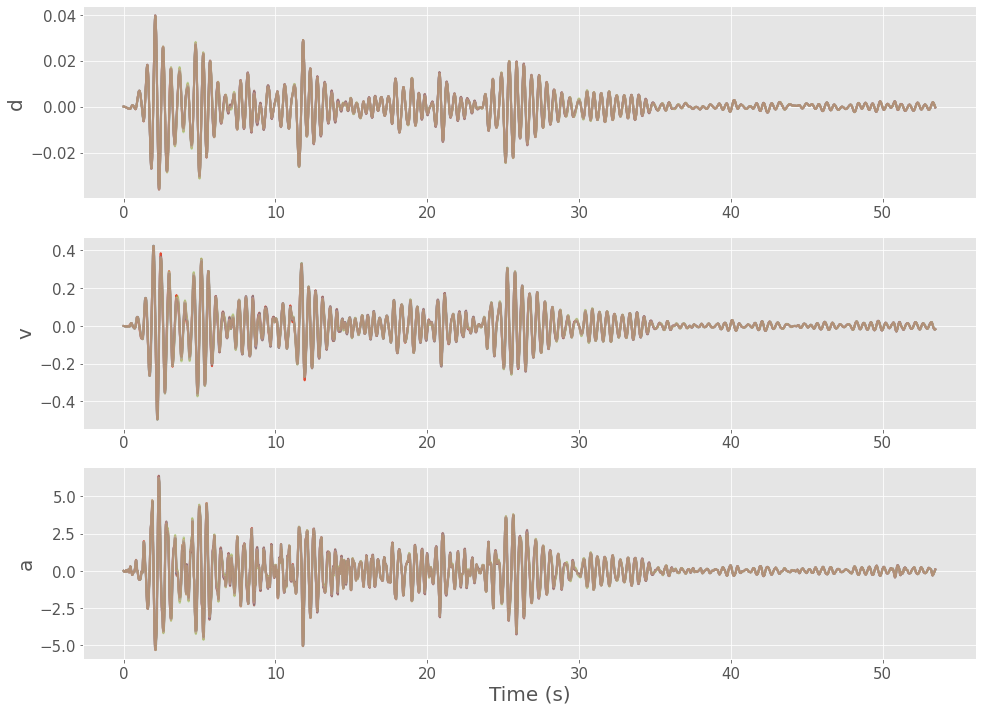

In [15]:
plot_obj = [[d1,d2,d3,d4,d5,d6,d7,d8,d9],[v1,v2,v3,v4,v5,v6,v7,v8,v9],[a1,a2,a3,a4,a5,a6,a7,a8,a9]]
ylabels = ['d',"v", 'a']
fig, axs = plt.subplots(3,1, figsize=(16,12))
for i in range(3):
    ax = axs[i]
    for j, dva in enumerate(plot_obj[i]):
        ax.plot(ts,dva, lw=2, alpha=1-j*0.1, zorder=j)
    ax.set_ylabel(ylabels[i], fontsize=20)
    ax.tick_params(labelsize=15)
axs[-1].set_xlabel('Time (s)', fontsize=20)
plt.show();

似乎都差不多，看不出来啥

# 方法误差比较

我们以精确法为基准，进行各类方法的误差比较，误差定义为均方根误差MSE，就是先相减再平方再求和再平均再开根方 😥

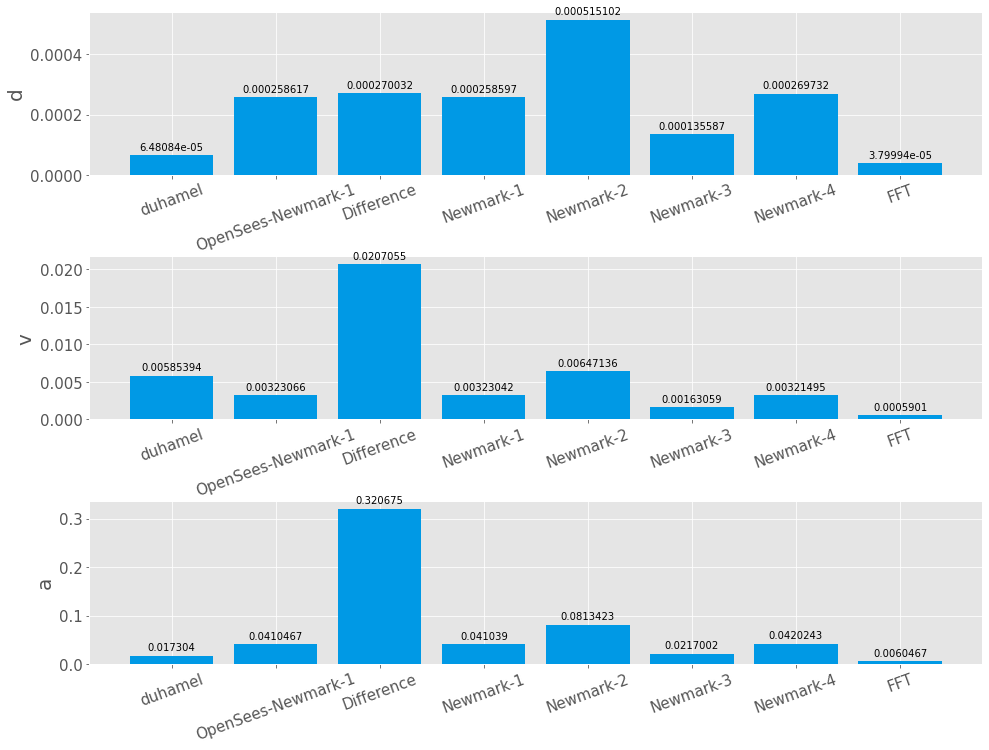

In [16]:
sdof_d = [d1,d3,d4,d5,d6,d7,d8,d9]
sdof_v = [v1,v3,v4,v5,v6,v7,v8,v9]
sdof_a = [a1,a3,a4,a5,a6,a7,a8,a9]
mse_d = [np.sqrt(np.sum((d - d2) ** 2) / len(d1)) for d in sdof_d]
mse_v = [np.sqrt(np.sum((v - v2) ** 2) / len(d1)) for v in sdof_v]
mse_a = [np.sqrt(np.sum((a - a2) ** 2) / len(d1)) for a in sdof_a]
plot_obj = [mse_d,mse_v,mse_a]
xticklabels = ["duhamel","OpenSees-Newmark-1","Difference","Newmark-1","Newmark-2","Newmark-3","Newmark-4","FFT"]
ylabels = ['d',"v", 'a']
fig, axs = plt.subplots(3,1, figsize=(16,12))
for i in range(3):
    ax = axs[i]
    h = ax.bar(range(len(mse_a)), plot_obj[i], lw=2, color="#0099e5")
    ax.bar_label(h, padding=3)
    ax.set_xticks(range(len(mse_a)))
    ax.set_xticklabels(xticklabels,fontsize=16,rotation=20)
    ax.set_ylabel(ylabels[i], fontsize=20)
    ax.tick_params(labelsize=15)
plt.subplots_adjust(hspace=0.5)
plt.show();

结果自行比较吧，FFT似乎挺准的，纽马克法-3也不错，而且我们实现的纽马克和OpenSees中的纽马克基本差不多(不一样应该是计算机舍入误差)。此外，纽马克对加速度响应作了太多假定了。

其实杜哈梅积分和中心差分可以更准，我们这里用的是地震波的时间步，也就是大家都用的相同的时间步。如果你把这两个方法的时间步加密，你会发现它们准的可怕，但是时间会让你痛苦。见下面

# 运行时间

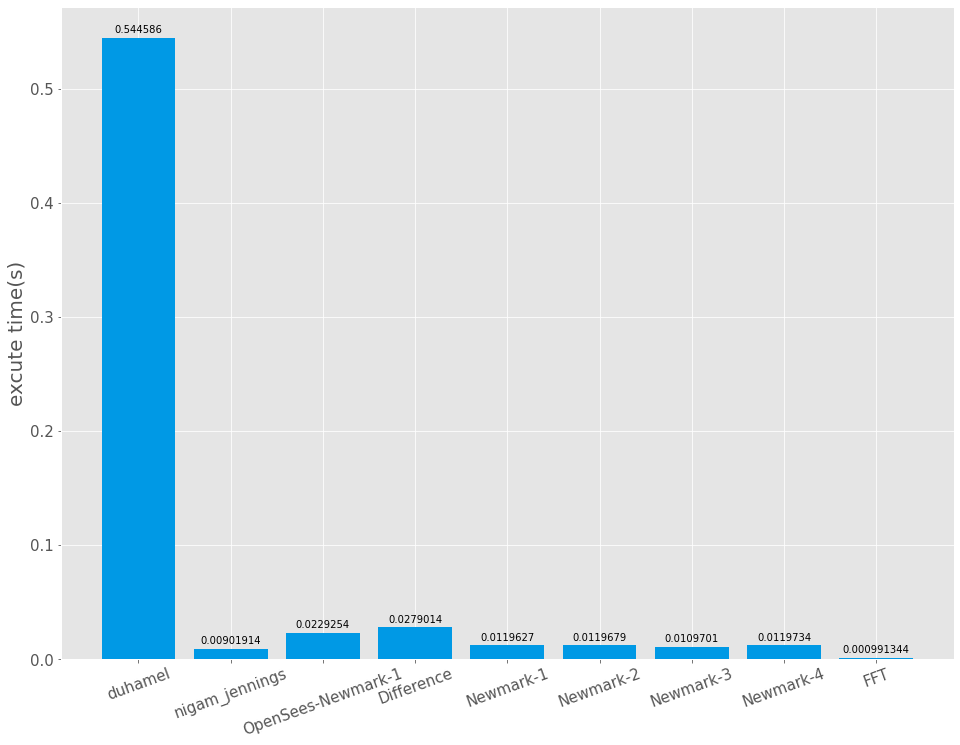

In [17]:

xticklabels = ["duhamel","nigam_jennings","OpenSees-Newmark-1","Difference","Newmark-1","Newmark-2","Newmark-3","Newmark-4","FFT"]
fig, ax = plt.subplots( figsize=(16,12))
h = ax.bar(range(len(excute_time)), excute_time, color="#0099e5")
ax.bar_label(h, padding=3)
ax.set_xticks(range(len(excute_time)))
ax.set_xticklabels(xticklabels,fontsize=16,rotation=20)
ax.set_ylabel("excute time(s)", fontsize=20)
ax.tick_params(labelsize=15)
plt.subplots_adjust(hspace=0.5)
plt.show();

杜哈梅积分这恐怖的运行时间，以后看看能不能优化代码。

最后可以看出，快速傅里叶变换毫无悬念胜出，一个2674个点的地震波用了0.001秒，而且还准。我们还在函数中作了三次逆傅里叶变换，位移，速度和加速度各一次。

以后求反应谱我们还是用 FFT 吧。

最后，我们应该替python辩解一下，纯python或许很慢，但python并不一定慢，因为我们有numpy。

# 动画演示

最养眼的时刻到了，我们用 vedo 作个动画看看。

In [19]:

"""Simulation of an SDOF system under earthquake"""
from vedo import *

settings.allowInteraction = True  # allow mouse interaction while playing

# 注意下我们前面的最大响应大约是0.04m，要根据这个值设定大小尺寸
L = 0.0    # spring x position at rest
x0 = 0.05  # 小块子的位置
cube_l = 0.01
surface_shape = (0.12, 0.002, 0.05)   # 底面
wall_shape = (0.002, 0.05, 0.05)      # 背墙
# initial conditions
x = vector(x0, cube_l/2+surface_shape[1], 0)
sx0 = vector(0, cube_l/2+surface_shape[1], 0)

plt = Plotter(size=(1050, 600))
plt += Box(pos=(surface_shape[0]/2, 0, 0), length=surface_shape[0], width=surface_shape[1], height=surface_shape[2])  # 底面
plt += Box(pos=(0, wall_shape[1]/2-surface_shape[1], 0), length=wall_shape[0], width=wall_shape[1], height=wall_shape[2])  # 背墙

block = Cube(pos=x, side=cube_l, c="tomato")   # 单自由度块
#block.addTrail(offset=[0, cube_l, 0], lw=2, n=500)

spring = Spring(sx0, x, r=0.002, thickness=0.001)   # 弹簧

plt += [block, spring, __doc__]

video = Video("sdof_move.gif", fps=24, backend='ffmpeg') # backend='opencv'
pb = ProgressBar(0, len(d2)-2000, c="r")  # 我这里减去了2000个点，快一点,可以全部恢复
for i in pb.range():
    xnew = vector(x0+d2[i], cube_l/2+surface_shape[1], 0)  # position
    block.pos(xnew)  # update block position and trail
    spring.stretch(sx0, xnew)  # stretch helix accordingly

    plt.show(elevation=0.02, azimuth=0.1,interactive=False, zoom=1.5) # elevation=0.1, azimuth=0.1 旋转相机，不旋转去掉
    video.addFrame()
    if plt.escaped: break # if ESC is hit during the loop
    pb.print()
video.close() 
plt.interactive()

 ━━━━━━━━━━━━━━━━━━━━━━                               elapsed: 49s (13.7 it/s)        
 \save video saved as sdof_move.gif
